<a href="https://colab.research.google.com/github/KunalVaidya99/Music-Genre-Classification/blob/master/CNN_genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
!pip install pydub

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
print(tf.__version__)

1.15.2


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.makedirs('/content/spectrograms3sec')

In [ ]:
genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()

In [ ]:
for g in genres:
  path1 = os.path.join('/content/audio3sec',f'{g}')
  os.makedirs(path1)
  path = os.path.join('/content/gdrive/My Drive/spectrograms3sec',f'{g}')
  
  os. makedirs(path)


<Figure size 432x432 with 0 Axes>

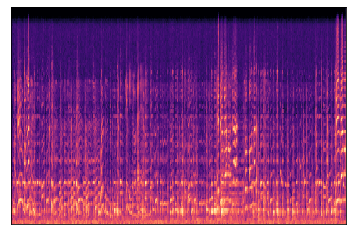

In [ ]:
import librosa.display
import skimage
y,sr = librosa.load('/content/gdrive/My Drive/kunal/genres/blues/blues.00020.wav')
mels = librosa.feature.melspectrogram(y=y,sr=sr)
plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111)
fig = plt.figure()
canvas = FigureCanvas(fig)
p = librosa.display.specshow(librosa.power_to_db(mels,ref=np.max))
z = librosa.power_to_db(mels,ref=np.max)
#print(z)
plt.savefig('/content/mel8.png')
plt.imsave('/content/mel7.png',z)

In [ ]:
from pydub import AudioSegment
newSong = 'newSong'
i = 0
for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('/content/gdrive/My Drive/kunal/genres',f"{g}")):

    song  =  os.path.join(f'/content/gdrive/My Drive/kunal/genres/{g}',f'{filename}')
    j = j+1
    for w in range(0,10):
      i = i+1
      #print(i)
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'/content/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

reggae
rock


In [ ]:
!zip -r /content/audio3sec.zip /content/audio3sec

Streaming output truncated to the last 5000 lines.
  adding: content/audio3sec/rock/rock966.wav (deflated 6%)
  adding: content/audio3sec/rock/rock551.wav (deflated 3%)
  adding: content/audio3sec/rock/rock370.wav (deflated 6%)
  adding: content/audio3sec/rock/rock456.wav (deflated 6%)
  adding: content/audio3sec/rock/rock598.wav (deflated 5%)
  adding: content/audio3sec/rock/rock457.wav (deflated 6%)
  adding: content/audio3sec/rock/rock312.wav (deflated 8%)
  adding: content/audio3sec/rock/rock608.wav (deflated 7%)
  adding: content/audio3sec/rock/rock213.wav (deflated 9%)
  adding: content/audio3sec/rock/rock108.wav (deflated 26%)
  adding: content/audio3sec/rock/rock231.wav (deflated 5%)
  adding: content/audio3sec/rock/rock601.wav (deflated 6%)
  adding: content/audio3sec/rock/rock762.wav (deflated 7%)
  adding: content/audio3sec/rock/rock190.wav (deflated 5%)
  adding: content/audio3sec/rock/rock462.wav (deflated 4%)
  adding: content/audio3sec/rock/rock202.wav (deflated 8%)
  ad

In [ ]:
#!pip install "librosa==0.6.0"
print(librosa.__version__)
for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('/content/audio3sec',f"{g}")):
    song  =  os.path.join(f'/content/audio3sec/{g}',f'{filename}')
    j = j+1
    
    y,sr = librosa.load(song,duration=3)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'/content/gdrive/My Drive/spectrograms3sec/{g}/{g+str(j)}.png')


0.6.3
reggae
rock


In [ ]:
directory = "/content/gdrive/My Drive/spectrograms3sec/train/"
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:100]

  for f in test_files:

    shutil.move(directory + f"{g}"+ "/" + f,"/content/gdrive/My Drive/spectrograms3sec/test/" + f"{g}")


KeyboardInterrupt: ignored

In [ ]:
train_dir = "/content/gdrive/My Drive/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/gdrive/My Drive/spectrograms3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)


Found 7964 images belonging to 9 classes.
Found 968 images belonging to 9 classes.


In [ ]:
def GenreModel(input_shape = (288,432,4),classes=9):
  np.random.seed(9)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=9))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=9))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model


In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model = GenreModel(input_shape=(288,432,4),classes=9)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 288, 432, 4)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 286, 430, 8)       296       
_________________________________________________________________
batch_normalization_12 (Batc (None, 286, 430, 8)       32        
_________________________________________________________________
activation_12 (Activation)   (None, 286, 430, 8)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 143, 215, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 141, 213, 16)      1168      
_________________________________________________________________
batch_normalization_13 (Batc (None, 141, 213, 16)      6

In [ ]:
model.fit_generator(train_generator,epochs=40,validation_data=vali_generator)


Epoch 1/40


/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)


 1/63 [..............................] - ETA: 1:22:33 - loss: 3.3061 - accuracy: 0.1484 - get_f1: 0.0544

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/63 [..............................] - ETA: 1:09:00 - loss: 3.0416 - accuracy: 0.1641 - get_f1: 0.0348

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 47 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/63 [>.............................] - ETA: 1:04:01 - loss: 2.7761 - accuracy: 0.1849 - get_f1: 0.0232

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/63 [>.............................] - ETA: 1:00:26 - loss: 2.5985 - accuracy: 0.1992 - get_f1: 0.0174

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/63 [=>............................] - ETA: 57:47 - loss: 2.4775 - accuracy: 0.2016 - get_f1: 0.0139  

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 61 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/63 [=>............................] - ETA: 55:58 - loss: 2.4085 - accuracy: 0.1953 - get_f1: 0.0141

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/63 [==>...........................] - ETA: 54:15 - loss: 2.3599 - accuracy: 0.1931 - get_f1: 0.0200

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/63 [==>...........................] - ETA: 52:43 - loss: 2.3027 - accuracy: 0.1992 - get_f1: 0.0299

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/63 [===>..........................] - ETA: 51:20 - loss: 2.2509 - accuracy: 0.2049 - get_f1: 0.0383

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 55 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/63 [===>..........................] - ETA: 50:04 - loss: 2.1988 - accuracy: 0.2148 - get_f1: 0.0454

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/63 [====>.........................] - ETA: 48:55 - loss: 2.1538 - accuracy: 0.2230 - get_f1: 0.0534

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/63 [====>.........................] - ETA: 47:56 - loss: 2.1141 - accuracy: 0.2272 - get_f1: 0.0651

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/63 [=====>........................] - ETA: 46:54 - loss: 2.0767 - accuracy: 0.2332 - get_f1: 0.0739

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/63 [=====>........................] - ETA: 45:52 - loss: 2.0555 - accuracy: 0.2321 - get_f1: 0.0770

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/63 [======>.......................] - ETA: 44:47 - loss: 2.0310 - accuracy: 0.2354 - get_f1: 0.0834

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/63 [======>.......................] - ETA: 43:44 - loss: 2.0039 - accuracy: 0.2373 - get_f1: 0.0952

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 51 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/63 [=======>......................] - ETA: 42:43 - loss: 1.9815 - accuracy: 0.2408 - get_f1: 0.1043

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 52 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/63 [=======>......................] - ETA: 41:39 - loss: 1.9563 - accuracy: 0.2478 - get_f1: 0.1112

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/63 [========>.....................] - ETA: 40:38 - loss: 1.9341 - accuracy: 0.2578 - get_f1: 0.1169

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/63 [=========>....................] - ETA: 37:01 - loss: 1.8928 - accuracy: 0.2658 - get_f1: 0.1327

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/63 [=========>....................] - ETA: 36:28 - loss: 1.8754 - accuracy: 0.2714 - get_f1: 0.1409

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/63 [=========>....................] - ETA: 35:35 - loss: 1.8597 - accuracy: 0.2736 - get_f1: 0.1455

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 44 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/63 [==========>...................] - ETA: 34:46 - loss: 1.8420 - accuracy: 0.2786 - get_f1: 0.1546

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/63 [==========>...................] - ETA: 33:54 - loss: 1.8225 - accuracy: 0.2877 - get_f1: 0.1636

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 53 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/63 [===========>..................] - ETA: 33:00 - loss: 1.8135 - accuracy: 0.2915 - get_f1: 0.1679

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/63 [===========>..................] - ETA: 32:09 - loss: 1.7969 - accuracy: 0.2974 - get_f1: 0.1749

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/63 [============>.................] - ETA: 31:17 - loss: 1.7841 - accuracy: 0.3014 - get_f1: 0.1798

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/63 [============>.................] - ETA: 30:25 - loss: 1.7753 - accuracy: 0.3037 - get_f1: 0.1814

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/63 [=============>................] - ETA: 29:32 - loss: 1.7664 - accuracy: 0.3061 - get_f1: 0.1819

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 22 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/63 [=============>................] - ETA: 28:37 - loss: 1.7572 - accuracy: 0.3087 - get_f1: 0.1857

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/63 [==============>...............] - ETA: 27:44 - loss: 1.7463 - accuracy: 0.3136 - get_f1: 0.1890

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/63 [==============>...............] - ETA: 26:52 - loss: 1.7353 - accuracy: 0.3191 - get_f1: 0.1948

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/63 [===============>..............] - ETA: 25:57 - loss: 1.7288 - accuracy: 0.3213 - get_f1: 0.1970

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 49 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/63 [===============>..............] - ETA: 25:05 - loss: 1.7216 - accuracy: 0.3233 - get_f1: 0.1996

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/63 [================>.............] - ETA: 24:11 - loss: 1.7139 - accuracy: 0.3256 - get_f1: 0.2025

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/63 [================>.............] - ETA: 23:18 - loss: 1.7030 - accuracy: 0.3294 - get_f1: 0.2072

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/63 [=================>............] - ETA: 22:25 - loss: 1.6966 - accuracy: 0.3319 - get_f1: 0.2096

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 60 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/63 [=================>............] - ETA: 21:33 - loss: 1.6877 - accuracy: 0.3336 - get_f1: 0.2127

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/63 [==================>...........] - ETA: 20:40 - loss: 1.6792 - accuracy: 0.3375 - get_f1: 0.2163

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 50 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/63 [==================>...........] - ETA: 19:45 - loss: 1.6689 - accuracy: 0.3411 - get_f1: 0.2209

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/63 [===================>..........] - ETA: 18:51 - loss: 1.6606 - accuracy: 0.3438 - get_f1: 0.2242

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/63 [===================>..........] - ETA: 17:57 - loss: 1.6551 - accuracy: 0.3444 - get_f1: 0.2261

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


44/63 [===================>..........] - ETA: 17:04 - loss: 1.6459 - accuracy: 0.3469 - get_f1: 0.2295

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 57 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/63 [====================>.........] - ETA: 16:11 - loss: 1.6411 - accuracy: 0.3472 - get_f1: 0.2311

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 54 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/63 [====================>.........] - ETA: 15:17 - loss: 1.6358 - accuracy: 0.3487 - get_f1: 0.2321

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/63 [=====================>........] - ETA: 14:23 - loss: 1.6300 - accuracy: 0.3519 - get_f1: 0.2343

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 46 could not be retrieved. It could be because a worker has died.
  UserWarning)


48/63 [=====================>........] - ETA: 13:29 - loss: 1.6247 - accuracy: 0.3536 - get_f1: 0.2371

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


49/63 [======================>.......] - ETA: 12:36 - loss: 1.6176 - accuracy: 0.3563 - get_f1: 0.2395

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 38 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/63 [======================>.......] - ETA: 11:41 - loss: 1.6112 - accuracy: 0.3603 - get_f1: 0.2409

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)


51/63 [=======================>......] - ETA: 10:48 - loss: 1.6066 - accuracy: 0.3619 - get_f1: 0.2408

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 59 could not be retrieved. It could be because a worker has died.
  UserWarning)


52/63 [=======================>......] - ETA: 9:54 - loss: 1.5991 - accuracy: 0.3652 - get_f1: 0.2424 

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/63 [========================>.....] - ETA: 9:00 - loss: 1.5934 - accuracy: 0.3689 - get_f1: 0.2453

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 56 could not be retrieved. It could be because a worker has died.
  UserWarning)


54/63 [========================>.....] - ETA: 8:06 - loss: 1.5883 - accuracy: 0.3713 - get_f1: 0.2484

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


55/63 [=========================>....] - ETA: 7:12 - loss: 1.5821 - accuracy: 0.3742 - get_f1: 0.2510

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


56/63 [=========================>....] - ETA: 6:18 - loss: 1.5767 - accuracy: 0.3772 - get_f1: 0.2534

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


57/63 [==========================>...] - ETA: 5:24 - loss: 1.5710 - accuracy: 0.3799 - get_f1: 0.2573

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/63 [==========================>...] - ETA: 4:30 - loss: 1.5668 - accuracy: 0.3822 - get_f1: 0.2595

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


59/63 [===========================>..] - ETA: 3:36 - loss: 1.5625 - accuracy: 0.3831 - get_f1: 0.2624

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 58 could not be retrieved. It could be because a worker has died.
  UserWarning)


60/63 [===========================>..] - ETA: 2:42 - loss: 1.5589 - accuracy: 0.3840 - get_f1: 0.2645

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 45 could not be retrieved. It could be because a worker has died.
  UserWarning)


61/63 [============================>.] - ETA: 1:48 - loss: 1.5546 - accuracy: 0.3856 - get_f1: 0.2667

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


62/63 [============================>.] - ETA: 54s - loss: 1.5501 - accuracy: 0.3864 - get_f1: 0.2695 

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 48 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/63 [==============================] - 3462s 55s/step - loss: 1.5479 - accuracy: 0.3872 - get_f1: 0.2701 - val_loss: 2.1692 - val_accuracy: 0.1736 - val_get_f1: 0.0000e+00
Epoch 2/40
63/63 [==============================] - 961s 15s/step - loss: 1.1776 - accuracy: 0.5578 - get_f1: 0.4343 - val_loss: 2.0242 - val_accuracy: 0.3533 - val_get_f1: 0.0000e+00
Epoch 3/40
63/63 [==============================] - 965s 15s/step - loss: 1.0353 - accuracy: 0.6177 - get_f1: 0.5270 - val_loss: 1.9596 - val_accuracy: 0.4545 - val_get_f1: 0.0818
Epoch 4/40
63/63 [==============================] - 973s 15s/step - loss: 0.9573 - accuracy: 0.6467 - get_f1: 0.5836 - val_loss: 1.7302 - val_accuracy: 0.4897 - val_get_f1: 0.3760
Epoch 5/40
63/63 [==============================] - 967s 15s/step - loss: 0.8915 - accuracy: 0.6743 - get_f1: 0.6300 - val_loss: 1.3075 - val_accuracy: 0.5279 - val_get_f1: 0.5017
Epoch 6/40
63/63 [==============================] - 966s 15s/step - loss: 0.8327 - accuracy: 0.7038 - 

In [ ]:

preds = model.evaluate(x=X_test,y=Y_test)
print(preds[1])
print(preds[2])



99/99 [==============================] - 1s 5ms/step
0.4343434274196625
0.3583858609199524
